*This is a Jupyter Notebook. It is an interactive document that contains both rich text elements such as figures, links, equations, etc. and executable code - in this case Python code (the grey boxes).
**How to use a Jupyter Notebook**: You can execute the blocks of code one at the time by placing the mouse in the grey box and pressing shift + enter. An asterisk will appear in the brackets at the top left of the box while the code is being executed (this may take few seconds) and turns into a number when the execution is over.*

# Manual calibration of the GR6J lumped rainfall-runoff model
Francesca Pianosi

This Notebooks helps getting familiar with the lumped rainfall-runoff model GR6J and the concept of model calibration. To this end, the model is run on an example catchment over a one year period, and a manual calibration of the model parameters is done using time series of river flows at the catchment outlet. The example catchment used here is the Wick River catchment in Scotland. River flow come from the gauging station at Tarroul: https://nrfa.ceh.ac.uk/data/station/spatial/1001

**<span style="color:blue">How to use this Notebook</span>** 
* Execute and assess the code cells one at the time. Read the brief explanation before each cell to understand what the code is doing, and use the questions afterwards to reflect on what the numerical results are showing. 
* For most code cells, you will not need to modify the code - just execute it. But it may be helpful to read the code (and comments) to get a better understanding of what is going on.

**<span style="color:blue">How to modify the Notebook for application to a different catchment</span>** 
* If you want to apply this Notebook to a different catchment, you only need to change the first line in the code cell **Load and plot a sample of the data** by replacing the file name "CAMELS_GB_1001.csv" with the name of the file where the time series for your catchment are saved. 
* This must be a csv file with three columns named "precipitation", "pet" and "discharge_spec" (as in the <span style="color:blue">header</span> of "CAMELS_GB_1001.csv"). Also, the three columns must not have gaps (or NaN) and all three variables must be expressed in <span style="color:blue">mm/day</span>.

### Import libraries

In [1]:
from __future__ import division, absolute_import, print_function

# General Python Packages needed for calculation
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Specific functions needed for model simulation and calibration
from GR6J import gr6j_sim as gr6j_sim
from PerfMetrics import CORR_ERR as CORR_ERR
from PerfMetrics import MEAN_ERR as MEAN_ERR
from PerfMetrics import STD_ERR as STD_ERR

# Python Packages for interactive visualisation in Jupyter Notebooks
from ipywidgets import interact, FloatRangeSlider, IntRangeSlider
import warnings
warnings.filterwarnings('ignore') # to hide warning messages
from IPython.display import display, HTML
# Increase size of output display cell:
display(HTML("""
<style>
    div.output_scroll {height: 40em; }
</style>
"""))

### Load and plot a sample of the data

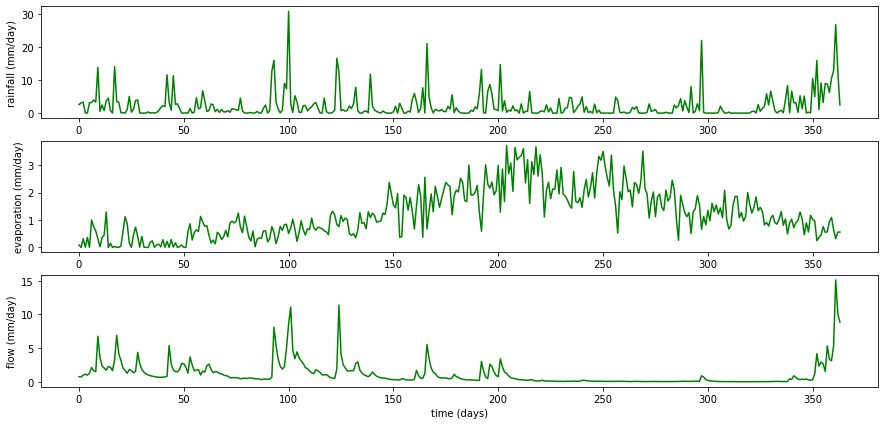

In [2]:
# Load the data:
data = pd.read_csv("CAMELS_GB_1001.csv")
rain = data["precipitation"].to_numpy() # (mm/year)
evap = data["pet"].to_numpy() # (mm/year)
flow = data["discharge_spec"].to_numpy() # (mm/year)

# Plot first year of data:
plt.figure(figsize=[15,7])
plt.subplot(311); plt.plot(rain[0:364],'g'); plt.ylabel('rainfall (mm/day)')
plt.subplot(312); plt.plot(evap[0:364],'g'); plt.ylabel('evaporation (mm/day)')
plt.subplot(313); plt.plot(flow[0:364],'g'); plt.ylabel('flow (mm/day)')
plt.xlabel('time (days)')
plt.show()

### Get familiar with the GR6J model
To begin with, we will run the GR6J model for the period of the data sample plotted above. The goal here is to familiarise with the model and the role that each parameter plays on the streamflow timeseries produced by it. 
To do this, we will set the five model parameters to some tentative values, run the model and plot the resulting streamflow time series. We can then change the parameter values one-at-a-time and look at how this changes the model predictions, and their fit to observed flows.

In [3]:
# Define interactive visualisation function to set the parameters to some tentative values, 
# run the model and plot the resulting streamflow time series

def oat_function(x1 = 200, x2 = 0.3, x3 = 100, x4 = 3, x5 = 0.6, x6 = 80 ):
    # Set a tentative parameterization:
    # X1	production store capacity [mm]
    # X2	intercatchment exchange coefficient [mm/d]
    # X3	routing store capacity [mm]
    # X4	unit hydrograph time constant [d]
    # X5	intercatchment exchange threshold [-]
    # X6	exponential store depletion coefficient [mm]
    
    
    # Run simulation:
    x = np.array([x1, x2, x3, x4, x5, x6]) 
    flow_sim, _, _ = gr6j_sim(x, rain[0:364], evap[0:364], np.zeros((3, )))

    # Plot hydrograph of observed and simulated flow:
    
    fig = plt.figure(figsize=[12,3])    
    plt.plot(flow[0:364], 'g') # observed flow
    plt.plot(flow_sim, 'k') # simulated flow
    plt.ylabel('flow (mm/day)')
    plt.xlabel('time (days)')
    plt.legend(['obs', 'sim'])    
    plt.show()
   
interact(oat_function, x1 = (0, 400, 1), x2 = (0, 3, 0.1), x3 = (10,150,1), x4 = (0,10,1), x5 = (0.1,1,0.1), x6 = (0.1,100,1));

interactive(children=(IntSlider(value=200, description='x1', max=400), FloatSlider(value=0.3, description='x2'…

### *Questions:*

* *What is the effect of varying each model parameter?* 
* *Which parameter controls which characteristic (timing, peak, recession phase, etc.) of the simulated flow time series?*
* *Can you find a combination of parameters that make the simulated time series (black line) "look like" the observed one (green)?*

### Use performance metrics to measure fit-to-data
In this section, we will define a range of performance metrics to establish, in a more formal way, the extent to which the simulated time series "look like" the observed one. In particular, we will focus on three hydrologically-relevant aspects: 

* does the model produce flow volumes comparable to what observed in reality? In mathematical terms, this can be established by comparing the mean of the simulated flow time series to the mean of the observed flow time series

* does the model exhibit a flow variability comparable to what observed in reality? This can be established by comparing the standard deviation of the simulated flow time series to that of the observed flow time series

* does the model reproduce the timing of the observed hydrograph? This can be establised by calculating the correlation between the simulated flow time series and the observed flow time series

We thus define the following performance metrics:

Timing: $ \ \ \ T = ( r - 1 )^2 \ \ $ where $ \ \ \ r = \text{correlation} ( Q^{sim}, Q^{obs} ) $
and $Q^{sim}$ ($Q^{obs}$) is the time series of simulated (observed) flow

Variability: $ \ \ \ V = ( S_{sim} / S_{obs} - 1 )^2 \ \ $ where $S_{sim}$ ($S^{obs}$) is the standard deviation of the time series $Q^{sim}$ ($Q^{obs}$).

Bias: $ \ \ \ B =  ( M_{sim} / M_{obs} - 1 )^2 \ \ $ where $M^{sim}$ ($M^{obs}$) is the mean of $Q^{sim}$ ($Q^{obs}$)

Note that the performance metrics above are defined in such a way that their optimal value is 0, that is, a "perfect" model that exactly reproduces the flow observations at all time steps would be associated with a performance of 0. Any value above 0 implies some level of "error" and the higher the performance metrics the larger that error.

In [5]:
# Same as before but we add performance metrics

def oat_function(x1 = 200, x2 = 1, x3 = 100, x4 = 3, x5 = 0.6, x6 = 80 ):
    
    # Run simulation:    
    x = np.array([x1, x2, x3, x4, x5, x6]) # 
    flow_sim, _, _ = gr6j_sim(x, rain[0:364], evap[0:364], np.zeros((3, )))
    
    # Calculate statistics of observed and simulated flows:
    S_obs = np.std(flow[0:364]); S_sim = np.std(flow_sim)
    M_obs = np.mean(flow[0:364]); M_sim = np.mean(flow_sim)
    
    # Calculate performance metrics:
    corr_err = CORR_ERR(flow_sim, flow[0:364])
    std_err = STD_ERR(flow_sim, flow[0:364]) 
    mean_err = MEAN_ERR(flow_sim, flow[0:364])
    
    fig = plt.figure(figsize=[11,6])    
    
    # Plot hydrograph of observed and simulated flow:
    ax0 = plt.subplot2grid((2,3), (0, 0), colspan=3)
    ax0.plot(flow[0:364], 'g') # observed flow
    ax0.plot(flow_sim, 'k') # simulated flow
    plt.ylabel('flow (mm/day)')
    plt.xlabel('time (days)')
    plt.legend(['obs', 'sim'])    
    
    # Plot statistics of observed and simulated flow:
    ax1 = plt.subplot2grid((2,3), (1, 0))
    ax1.barh(['S_obs','S_sim','M_obs','M_sim'],[S_obs,S_sim,M_obs,M_sim], color=['g','k','g','k'])
    plt.xlabel("(mm/day)"), plt.ylabel("flow statistics")
    
    # Plot statistics of observed and simulated flow:
    ax1 = plt.subplot2grid((2,3), (1, 1))
    ax1.plot(flow[0:364],flow[0:364],'g')
    ax1.plot(flow[0:364],flow_sim,'ok')
    plt.xlabel("obs flow (mm/day)"), plt.ylabel("sim flow (mm/day)")
    
    # Plot performance metrics:
    ax2 = plt.subplot2grid((2,3), (1, 2))
    ax2.bar(['T','V','B'],[float(corr_err),float(std_err),float(mean_err)], color='orange')
    plt.ylim([0,1]), plt.ylabel("error (-)")

    plt.tight_layout()
    plt.show()
   
interact(oat_function, x1 = (0, 400, 1), x2 = (0, 3, 0.1), x3 = (10,150,1), x4 = (0,10,1), x5 = (0.1,1,0.1), x6 = (0.1,100,1));

interactive(children=(IntSlider(value=200, description='x1', max=400), FloatSlider(value=1.0, description='x2'…

### Questions
* Is your visual assessment of the "similarity" of observed and simulated time series (top panel) consistent with the associated performance metrics (bottom right)?
* Is it possible to find a combination of parameters that "does well" on all metrics?